In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn.model_selection import cross_validate,train_test_split
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function

%matplotlib inline

In [0]:
boston = learn.datasets.load_dataset('boston')
#print( "boston = ", boston )
x, y = boston.data, boston.target
y.resize( y.size, 1 ) #make y = [[x], [x], [x], ... ]
train_x, test_x, train_y, test_y =train_test_split(
x, y, test_size=0.2, random_state=42)
print( "Dimension of Boston test_x = ", test_x.shape )
print( "Dimension of test_y = ", test_y.shape )
print( "Dimension of Boston train_x = ", train_x.shape )
print( "Dimension of train_y = ", train_y.shape )


Dimension of Boston test_x =  (102, 13)
Dimension of test_y =  (102, 1)
Dimension of Boston train_x =  (404, 13)
Dimension of train_y =  (404, 1)


In [0]:
scaler = preprocessing.StandardScaler( )
train_x = scaler.fit_transform( train_x )
test_x = scaler.fit_transform( test_x )


In [0]:
numFeatures = train_x.shape[1]
print( "number of features = ", numFeatures )

number of features =  13


In [0]:
with tf.name_scope("IO"):
  inputs = tf.placeholder(tf.float32, [None, numFeatures], name="X")
  outputs = tf.placeholder(tf.float32, [None, 1], name="Yhat")

In [0]:
with tf.name_scope("LAYER"):
    # network architecture
    Layers = [numFeatures, 52, 39, 26, 13, 1]
    
    h1   = tf.Variable(tf.random_normal([Layers[0], Layers[1]], 0, 0.1, dtype=tf.float32), name="h1")
    h2   = tf.Variable(tf.random_normal([Layers[1], Layers[2]], 0, 0.1, dtype=tf.float32), name="h2")
    h3   = tf.Variable(tf.random_normal([Layers[2], Layers[3]], 0, 0.1, dtype=tf.float32), name="h3")
    h4   = tf.Variable(tf.random_normal([Layers[3], Layers[4]], 0, 0.1, dtype=tf.float32), name="h4")
    hout = tf.Variable(tf.random_normal([Layers[4], Layers[5]], 0, 0.1, dtype=tf.float32), name="hout")

    b1   = tf.Variable(tf.random_normal([Layers[1]], 0, 0.1, dtype=tf.float32 ), name="b1" )
    b2   = tf.Variable(tf.random_normal([Layers[2]], 0, 0.1, dtype=tf.float32 ), name="b2" )
    b3   = tf.Variable(tf.random_normal([Layers[3]], 0, 0.1, dtype=tf.float32 ), name="b3" )
    b4   = tf.Variable(tf.random_normal([Layers[4]], 0, 0.1, dtype=tf.float32 ), name="b4" )
    bout = tf.Variable(tf.random_normal([Layers[5]], 0, 0.1, dtype=tf.float32 ), name="bout" )

In [0]:
def model( inputs, layers ):
    [h1, b1, h2, b2, h3, b3, hout, bout] = layers
    y1 = tf.add( tf.matmul(inputs, h1), b1 )
    y1 = tf.nn.sigmoid( y1 )
       
    y2 = tf.add( tf.matmul(y1, h2), b2 )
    y2 = tf.nn.sigmoid( y2 )

    y3 = tf.add( tf.matmul(y2, h3), b3 )
    y3 = tf.nn.sigmoid( y3 )

    y4 = tf.add( tf.matmul(y3, h4), b4 )
    y4 = tf.nn.sigmoid( y4 )

    yret  = tf.matmul(y4, hout) + bout 
    return yret

In [0]:
with tf.name_scope("train"):
    learning_rate = 0.50
    yout = model( inputs, [h1, b1, h2, b2, h3, b3, hout, bout] )
    
    cost_op = tf.reduce_mean( tf.pow( yout - outputs, 2 ))
    #cost_op = tf.reduce_sum( tf.pow( yout - outputs, 2 ))
    #cost_op =  tf.reduce_mean(-tf.reduce_sum( yout * tf.log( outputs ) ) )

    #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_op)
    #train_op = tf.train.AdamOptimizer( learning_rate=learning_rate ).minimize( cost_op )
    train_op = tf.train.AdagradOptimizer( learning_rate=learning_rate ).minimize( cost_op )

W0802 22:36:36.549398 140110409021312 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0802 22:36:36.638106 140110409021312 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
# define variables/constants that control the training
epoch = 0
last_cost = 0
max_epochs = 50000
tolerance = 1e-6

print( "Beginning Training" )

sess = tf.Session() # Create TensorFlow session
with sess.as_default():
    
    # initialize the variables
    init = tf.initialize_all_variables()
    sess.run(init)
    
    # start training until we stop, either because we've reached the max
    # number of epochs, or successive errors are close enough to each other
    # (less than tolerance)
    
    costs = []
    epochs= []
    while True:
        # Do the training
        sess.run( train_op, feed_dict={inputs: train_x, outputs: train_y} )
            
        # Update the user every 1000 epochs
        if epoch % 1000==0:
            cost = sess.run(cost_op, feed_dict={inputs: train_x, outputs: train_y})
            costs.append( cost )
            epochs.append( epoch )
            
            print( "Epoch: %d - Error: %.4f" %(epoch, cost) )
            
            # time to stop?
            if epoch > max_epochs :
                # or abs(last_cost - cost) < tolerance:
                print( "STOP!" )
                break
            last_cost = cost
            
        epoch += 1
    
    # we're done...
    # print some statistics...
    
    print( "Test Cost =", sess.run(cost_op, feed_dict={inputs: test_x, outputs: test_y}) )

    # compute the predicted output for test_x
    pred_y = sess.run( yout, feed_dict={inputs: test_x, outputs: test_y} )
    
    print( "\nPrediction\nreal\tpredicted" )
#     for (y, yHat ) in zip( test_y, pred_y )[0:10]:
#         print( "%1.1f\t%1.1f" % (y, yHat ) )
    

Beginning Training
Epoch: 0 - Error: 376.1202
Epoch: 1000 - Error: 2.1602
Epoch: 2000 - Error: 0.9187
Epoch: 3000 - Error: 0.6364
Epoch: 4000 - Error: 0.4874
Epoch: 5000 - Error: 0.3562
Epoch: 6000 - Error: 0.2887
Epoch: 7000 - Error: 0.2575
Epoch: 8000 - Error: 0.2321
Epoch: 9000 - Error: 0.2062
Epoch: 10000 - Error: 0.1813
Epoch: 11000 - Error: 0.1562
Epoch: 12000 - Error: 0.1437
Epoch: 13000 - Error: 0.1356
Epoch: 14000 - Error: 0.1061
Epoch: 15000 - Error: 0.0813
Epoch: 16000 - Error: 0.0712
Epoch: 17000 - Error: 0.0754
Epoch: 18000 - Error: 0.0598
Epoch: 19000 - Error: 0.0562
Epoch: 20000 - Error: 0.0486
Epoch: 21000 - Error: 0.0434
Epoch: 22000 - Error: 0.0390
Epoch: 23000 - Error: 0.0361
Epoch: 24000 - Error: 0.0301
Epoch: 25000 - Error: 0.0263
Epoch: 26000 - Error: 0.0241
Epoch: 27000 - Error: 0.0204
Epoch: 28000 - Error: 0.0183
Epoch: 29000 - Error: 0.0164
Epoch: 30000 - Error: 0.0145
Epoch: 31000 - Error: 0.0138
Epoch: 32000 - Error: 0.0128
Epoch: 33000 - Error: 0.0120
Epoch:

In [0]:
r2 =  metrics.r2_score(test_y, pred_y) 
print( "mean squared error = ", metrics.mean_squared_error(test_y, pred_y))
print( "r2 score (coef determination) = ", metrics.r2_score(test_y, pred_y))

mean squared error =  15.846934652273562
r2 score (coef determination) =  0.783906762076779


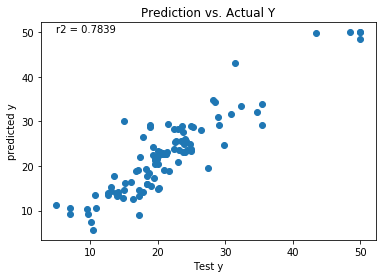

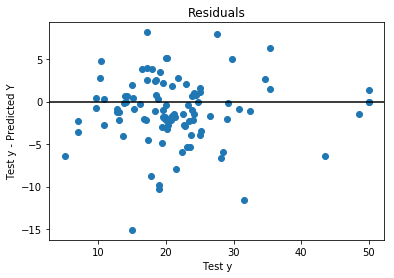

In [0]:
    
    fig = plt.figure()
    plt.scatter( test_y, pred_y )
    plt.text(5, 50, r'r2 = %1.4f' % r2)
    plt.xlabel( "Test y" )
    plt.ylabel( "predicted y" )
    plt.title( "Prediction vs. Actual Y" )
    #plt.save( "images/sigmoid_adagrad_52_39_26_13_1.png")
    plt.show()
    fig.savefig('PredVsRealBoston.png', bbox_inches='tight')
    
    fig = plt.figure()
    plt.scatter( test_y, test_y - pred_y )
    plt.axhline(0, color='black')
    plt.xlabel( "Test y" )
    plt.ylabel( "Test y - Predicted Y" )
    plt.title( "Residuals" )
    plt.show()
    fig.savefig('ResidualsBoston.png', bbox_inches='tight')
    

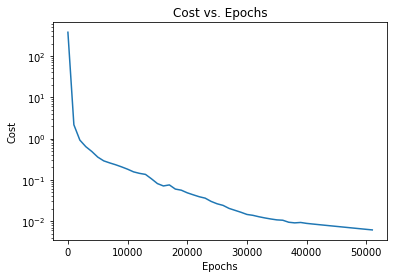

In [0]:
    fig = plt.figure()
    plt.semilogy( epochs, costs )
    plt.xlabel( "Epochs" )
    plt.ylabel( "Cost" )
    plt.title( "Cost vs. Epochs")
    plt.show()
    fig.savefig('CostVsEpochs.png', bbox_inches='tight')